# **Overview**

Goal of this application is to compare the performance of the classifiers

*   K-nearest neighbors
*   Logistic Regression
*   Decision Trees
*   Support Vector Machines

Key performance parameters assessed and analyzed are

*   F1 Score (Imbalanced classes)
*   Latency



# **Business Understanding**

Objective is to understand if customer would subscribe to a term product offered by banks to it's customers by direct outbound reach



# **Data Sources**

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

URL: https://archive.ics.uci.edu/dataset/222/bank+marketing






In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score, f1_score, ConfusionMatrixDisplay, average_precision_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

#EDA (Non-linear feature analysis)
from sklearn.feature_selection import mutual_info_classif, r_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import partial_dependence

import warnings

In [15]:
df=pd.read_csv('data/bank-full.csv',delimiter=';')

In [16]:
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


# **Understanding the data**


* Run summary stats on dataset

* Understand dataset for missing values; Quantify the size of missing data to determine if they should be dropped/imputed
* Determine categorical dimensions that could be used: Nominal /Ordinal

In [5]:
#Source: https://github.com/toby-gardner-ai/uc-berkeley-aiml-course/blob/main/notebooks/Mod4_Data_Analytics.ipynb
def summary_stats(df) -> pd.DataFrame:

    # Create base frame
    stats = pd.DataFrame(index=df.columns)

    stats["dtype"] = df.dtypes


    stats["sample_val"] = [df[col].dropna().sample(1).iloc[0]
                            if df[col].notna().any() else np.nan
                            for col in df.columns]

    stats["vals"] = df.count()
    stats["miss_pct"] = (df.isna().sum() / len(df) * 100).round(1)
    stats["unique"] = df.nunique()

    # Initiate Descriptive Stats
    for col in ["mean", "mode", "min", "max", "std", "skew", "kurtosis"]:
        stats[col] = np.nan

    # Compute stats for numeric columns
    num_cols = df.select_dtypes(include="number").columns

    for col in num_cols:
        s = df[col].dropna()
        if not s.empty:
            stats.at[col, "mean"] = s.mean()
            stats.at[col, "min"] = s.min()
            stats.at[col, "max"] = s.max()
            stats.at[col, "std"] = s.std()
            #stats.at[col, "skew"] = s.skew().round(1)
            #stats.at[col, "kurtosis"] = s.kurtosis().round(1)
            mode_vals = s.mode()
            stats.at[col, "mode"] = mode_vals.iloc[0] if not mode_vals.empty else np.nan

    # Rounding preferences for numeric stats (change this to suit dataset)
    round_cols = ["mean", "mode", "min", "max", "std"]
    stats[round_cols] = stats[round_cols].round(2)

    return stats

In [13]:
summary_stats(df)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
age,int64,57,45211,0.0,77,40.94,32.0,18.0,95.0,10.62,NaN,NaN
job,object,housemaid,45211,0.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,object,single,45211,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,object,tertiary,45211,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,object,no,45211,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,int64,541,45211,0.0,7168,1362.27,0.0,-8019.0,102127.0,3044.77,NaN,NaN
housing,object,yes,45211,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,object,no,45211,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,object,cellular,45211,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,int64,3,45211,0.0,31,15.81,20.0,1.0,31.0,8.32,NaN,NaN


In [22]:
df['poutcome'].value_counts()

,count
poutcome,
unknown,36959
failure,4901
other,1840
success,1511


In [13]:
df['month'].value_counts()

,count
month,
may,13766
jul,6895
aug,6247
jun,5341
nov,3970
apr,2932
feb,2649
jan,1403
oct,738


**Feature Engineering**
-
**1. DROP Duration** - last contact duration, in seconds (numeric).
Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model *(Completed)*

**2. Ordinal Encoding** for Education *(Completed)*

**3. One hot encoding** for Job, Marital Status *(Completed)*

**4. Cycling encoding** for day and month of contact *(Completed)*

**5. Standard Scalar** application for Logistic Regression and SVM *(Applied individually before algorithms)*

**6. Data transformation**

*   Set pdays into a binary flag indicating if they have been contacted or not
*   No missing data and hence no imputation needed








# Data assumptions made

1. While Year is missing, 'Month' and 'Day' serve as proxies for seasonal financial behavior and monthly payroll cycles

In [18]:
from sklearn.preprocessing import OneHotEncoder

#2. Ordinal Encoding
edu_mapping = {
    'unknown': 0,
    'primary': 1,
    'secondary': 2,
    'tertiary': 3
}
pr_out_mapping={
    'unknown': 0,
    'failure': 1,
    'other': 2,
    'success': 3
}

# Apply to the dataframe
df['education_encoded'] = df['education'].map(edu_mapping)
df['poutcome_encoded'] = df['poutcome'].map(pr_out_mapping)


# 3. One Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
cols = ['job', 'marital','contact','housing','loan','default']
encoded_data = encoder.fit_transform(df[cols])
data_1 = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(cols))
# Combine back with the original dataframe
df = pd.concat([df.drop(columns=cols), data_1], axis=1)

# 4.Cyclical Encoding
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
             'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df['month_num'] = df['month'].map(month_map)
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# 6. Dropping duration pdays number of days that passed by after the client was last contacted from a previous campaign
df['pdays']=np.where(df['pdays']==999,0,1)


# 1. Dropping duration
data=df.drop(columns=['duration','education','poutcome','month', 'month_num', 'day'])

In [19]:
data.head(5)

,age,balance,campaign,pdays,previous,y,education_encoded,poutcome_encoded,job_admin.,job_blue-collar,...,housing_no,housing_yes,loan_no,loan_yes,default_no,default_yes,month_sin,month_cos,day_sin,day_cos
0,58,2143,1,1,0,no,3,0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.5,-0.866025,0.848644,0.528964
1,44,29,1,1,0,no,2,0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.5,-0.866025,0.848644,0.528964
2,33,2,1,1,0,no,2,0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.5,-0.866025,0.848644,0.528964
3,47,1506,1,1,0,no,0,0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.5,-0.866025,0.848644,0.528964
4,33,1,1,1,0,no,0,0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.5,-0.866025,0.848644,0.528964


In [72]:
cont_features=['age','balance','campaign','previous','month_sin','month_cos','day_sin','day_cos']

# Review Mutual Information and Correlation to understand non-linear features

In [20]:
X=data.drop(columns=['y'])
y=data['y'].map({'no': 0, 'yes': 1})

In [56]:
# Source: https://github.com/toby-gardner-ai/uc-berkeley-aiml-course/blob/main/notebooks/Mod16_Nonlinear_feat_SVM.ipynb

y_numeric = y.map({'no': 0, 'yes': 1})
corr = pd.Series(np.abs(r_regression(X, y_numeric)),index=X.columns)

X_scaled = StandardScaler().fit_transform(X)
mi = pd.Series(mutual_info_classif(X_scaled, y_numeric, random_state=42), index=X.columns)

mi_corr_df = (pd.DataFrame({"corr": corr,"mi": mi}).sort_values("mi", ascending=False))
mi_corr_df.head()

,corr,mi
poutcome_encoded,0.259315,0.031916
balance,0.052838,0.022138
month_cos,0.099602,0.021083
month_sin,0.010559,0.017902
contact_unknown,0.150935,0.017384


/usr/local/lib/python3.12/dist-packages/matplotlib/transforms.py:351: RuntimeWarning:

invalid value encountered in scalar subtract



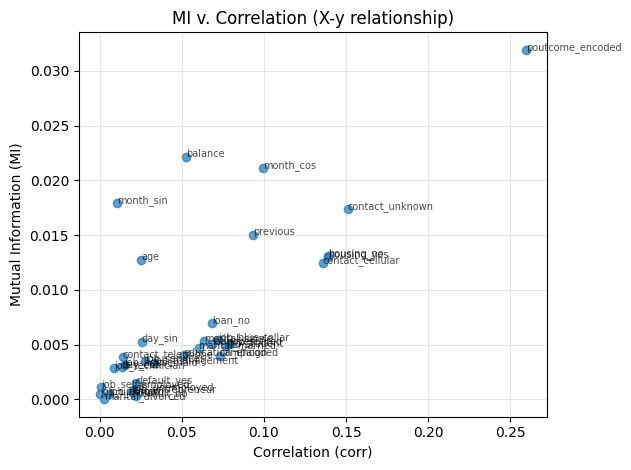

<Figure size 640x480 with 0 Axes>

In [57]:

plt.scatter(mi_corr_df["corr"],mi_corr_df["mi"],alpha=0.7)

for feature in mi_corr_df.index:
    plt.text(
        mi_corr_df.loc[feature, "corr"],
        mi_corr_df.loc[feature, "mi"],
        feature,
        fontsize=7,
        alpha=0.7
    )

plt.xlabel("Correlation (corr)")
plt.ylabel("Mutual Information (MI)")
plt.title("MI v. Correlation (X-y relationship)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('images/MI_vs_Correlation.png')

# Partial Dependency Plots

In [46]:
rf_pdp = RandomForestClassifier(n_estimators=400,random_state=42,n_jobs=-1,class_weight="balanced")
rf_pdp.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [87]:
pdp_rows = []
grid_resolution = 50
# Ensure we only look at features that have actual variation in X
valid_features = [f for f in cont_features if X[f].nunique() > 1]

for feature in valid_features:
    # 1. Calculate PDP for the current feature
    pd_out = partial_dependence(
        rf_pdp,
        X,
        features=[feature],
        grid_resolution=grid_resolution
    )

    avg = np.array(pd_out["average"])
    grid = pd_out["grid_values"][0]
    classes = list(rf_pdp.classes_)

    # --- INDENTED: Now we save data for THIS feature before the loop moves on ---
    for class_idx, class_label in enumerate(classes):
        # Handle binary vs multiclass shape differences
        data_idx = class_idx if avg.shape[0] > 1 else 0

        # Calculate values (handling binary P vs 1-P logic)
        if avg.shape[0] == 1 and class_idx == 0:
            pdp_values = 1 - avg[0]
        else:
            pdp_values = avg[data_idx]

        for feat, pdp_val in zip(grid, pdp_values):
            pdp_rows.append({
                "feature": feature,
                "class": class_label,
                "feature_value": feat,
                "pdp": float(pdp_val)
            })

# Now pdp_df will contain data for ALL features
pdp_df = pd.DataFrame(pdp_rows)

In [86]:
pdp_df[pdp_df['class']=='yes'].head()

,feature,class,feature_value,pdp
26,day_cos,yes,-0.994869,0.141510
27,day_cos,yes,-0.994869,0.141510
28,day_cos,yes,-0.954139,0.128009
29,day_cos,yes,-0.874347,0.129722
30,day_cos,yes,-0.874347,0.129722


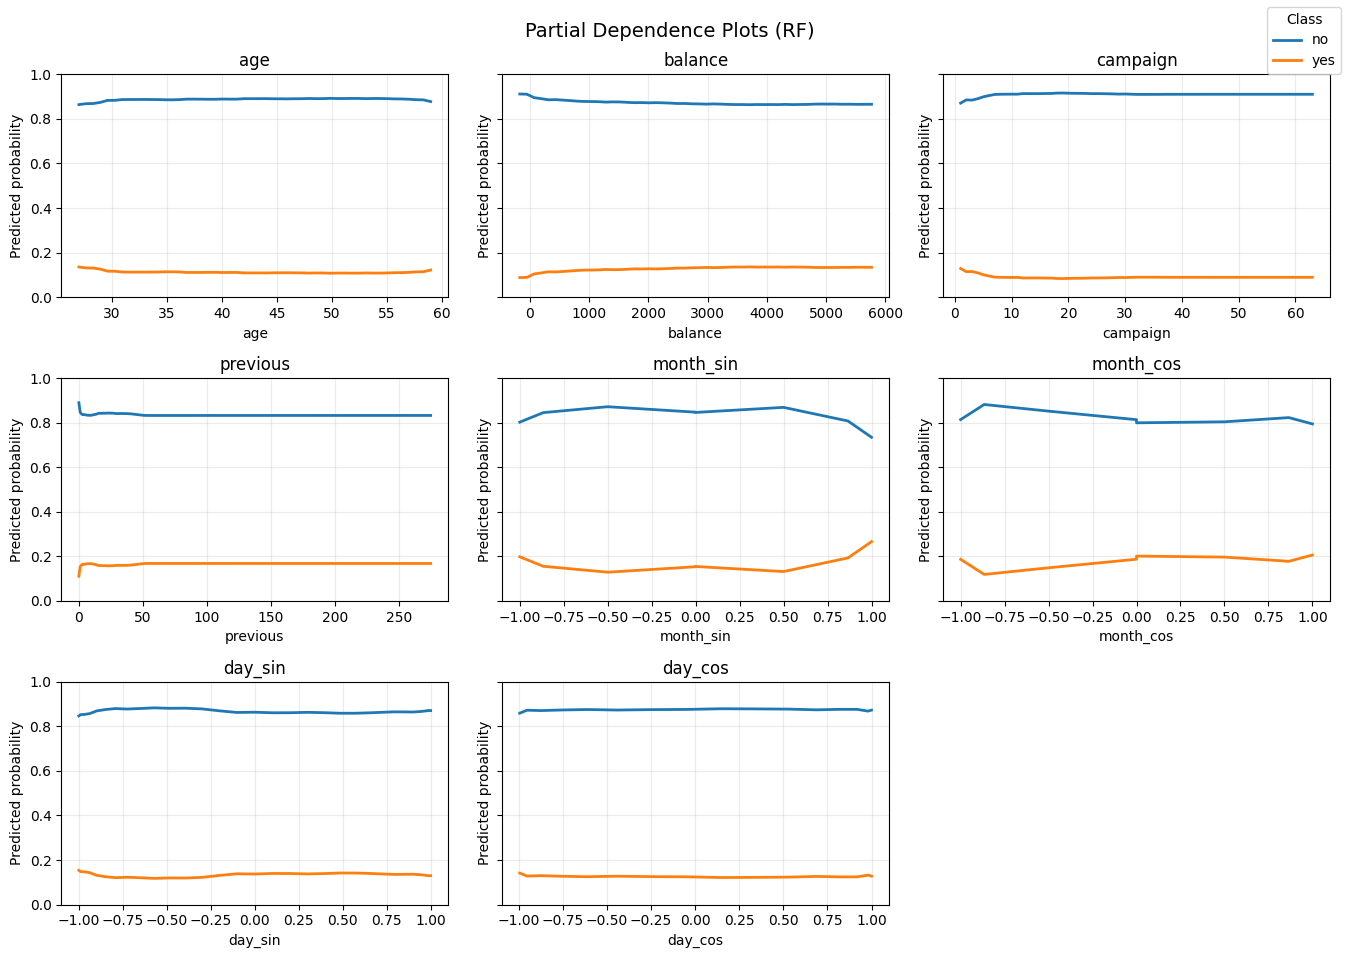

<Figure size 640x480 with 0 Axes>

In [89]:
n_cols = 3
n_rows = int(np.ceil(len(valid_features) / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4.5 * n_cols, 3.2 * n_rows),
    sharey=True
)

axes = np.array(axes).reshape(-1)

classes = df["y"].unique()
colors = plt.cm.tab10.colors[:len(classes)]

for i, feature in enumerate(valid_features):
    ax = axes[i]

    feature_df = pdp_df[pdp_df["feature"] == feature]

    for c, color in zip(classes, colors):
        class_df = feature_df[feature_df["class"] == c]

        ax.plot(
            class_df["feature_value"],
            class_df["pdp"],
            label=str(c),
            linewidth=2,
            color=color
        )

    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Predicted probability")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.25)

# Drop empty charts
for ax in axes[len(valid_features):]:
    ax.axis("off")

fig.suptitle("Partial Dependence Plots (RF)", fontsize=14)
fig.legend(
    [str(c) for c in classes],
    title="Class",
    loc="upper right"
)

plt.tight_layout()
plt.show()
plt.savefig('images/Partial_dependency_plot.png')

# Summarizing insights from Mutual Information vs Correlation and Partial Dependency Plots

**Mutual Information vs Correlation Plots**

*   month_sin, month_cos and balance has low correlation (linearity) but high mutual information, suggesting non-linear features contributing to the outcome

*   job, marital status etc. have low correlation and mutual information and likely to have limited influence on outcome. Should the model overfit, look to remove these features

**Partial Dependency Plots**


*   Age remains largely flat from 30 to 60, showing low dependency
*   Monthly data shows seasonality, with conversions being higher during certain months
*   Campaign data shows declining after the initial few outreaches similar to diminish rate of returns seen commonly with marketing campaigns










# ** **Model development and assessment of algorithms**

Algorithms assessed
1. SVM
2. K Nearest Neighbors
3. Logistic Regression
4. Decision Trees

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

# Baseline Model Numbers

In [6]:
# Dummy Baseline (FYI most frequent was Class no at 0.89)
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)
print("Dummy accuracy:", accuracy_score(y_test, dummy_pred))
print("Dummy macro F1:", round(f1_score(y_test, dummy_pred, average="macro"), 2))

Dummy accuracy: 0.8830399009112625
Dummy macro F1: 0.47


# Identifying Best Hyper parameters across the algorithms
# 1. SVM

In [7]:
#SVM
svm_pipe = Pipeline([("scaler", StandardScaler()),("svc", SVC(class_weight='balanced')),])
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [8]:
param_grid = [
    {
        "svc__kernel": ["linear"],
        "svc__C": [0.1, 1, 10],
    },
    {
        "svc__kernel": ["rbf"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", "auto"],
    },
    {
        "svc__kernel": ["poly"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", "auto", 0.01, 0.1],
        "svc__degree": [2, 3],
        "svc__coef0": [0.0, 1.0],
    },
    {
        "svc__kernel": ["sigmoid"],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
        "svc__coef0": [0.0, 1.0],
    },
]

In [9]:
from sklearn.model_selection import RandomizedSearchCV

search_random = RandomizedSearchCV(
    estimator=svm_pipe,
    param_distributions=param_grid, # You can use the same grid as before
    n_iter=20,                     # It will only pick 20 random combinations
    scoring="average_precision",
    n_jobs=-1,                     # Colab Pro gives you more cores; use them!
    cv=cv,
    refit=True,
    verbose=3,                     # Higher verbosity shows you which "fit" is running
    random_state=42
)

search_random.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search_random.best_score_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best parameter (CV score=0.365):


In [16]:
print(search_random.best_params_)

{'svc__kernel': 'poly', 'svc__gamma': 'auto', 'svc__degree': 2, 'svc__coef0': 0.0, 'svc__C': 0.1}


In [17]:
# search = GridSearchCV(
#     estimator=svm_pipe,
#     param_grid=param_grid,
#     scoring="average_precision",
#     n_jobs=-1,
#     cv=cv,
#     refit=True,
#     verbose=0,
# )

# search.fit(X_train, y_train)

# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

In [12]:
res = pd.DataFrame(search_random.cv_results_)

df = pd.concat([res[["mean_test_score", "mean_fit_time"]],res["params"].apply(pd.Series)],axis=1
    ).rename(columns={
        "mean_test_score": "average_precision",
        "mean_fit_time": "latency",
        "svc__C": "c_param",
        "svc__kernel": "kernel",
        "svc__gamma": "gamma_param",
        "svc__coef0": "coef0_param",
        "svc__degree": "degree_param",
    })

core_cols = ["kernel", "average_precision", "latency"]
param_cols = [c for c in df.columns if c.endswith("_param") and c not in core_cols]

df = df[core_cols + param_cols].sort_values(by=["average_precision", "latency"],ascending=[False, True])

df.head(10)

,kernel,average_precision,latency,gamma_param,coef0_param,c_param,degree_param
6,poly,0.365396,52.211128,auto,0.0,0.1,2.0
7,poly,0.365118,54.283880,auto,1.0,0.1,2.0
3,poly,0.364685,45.582280,auto,1.0,0.1,3.0
16,poly,0.360916,38.142253,scale,1.0,1.0,2.0
2,poly,0.358581,48.885412,auto,0.0,1.0,2.0
8,rbf,0.358195,74.200700,auto,NaN,0.1,NaN
4,poly,0.358051,51.159607,0.1,0.0,0.1,2.0
18,poly,0.355191,50.920418,0.01,1.0,10.0,3.0
1,linear,0.331421,42.050470,NaN,NaN,0.1,NaN
12,poly,0.313052,120.237507,scale,1.0,10.0,3.0


**Summary**

Top performing hyper parameters are polynomial kernels showing interactions of degree 2/3



In [13]:
res.to_csv('res_svm.csv', index=False)

# 2. Logistic Regression

In [ ]:
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000, random_state=42)),
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_linear = [
    {
        "logreg__penalty": ["l2"],
        "logreg__C": [0.01, 0.1, 1, 10],
        "logreg__solver": ["lbfgs", "newton-cg", "saga"],
        'logreg__class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
    },
    {
        "logreg__penalty": ["l1"],
        "logreg__C": [0.01, 0.1, 1, 10],
        "logreg__solver": ["saga"],
        'logreg__class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
    },
]

search_linear = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_linear,
    scoring="average_precision",
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=0,
)

search_linear.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search_linear.best_score_)
print(search_linear.best_params_)

Best parameter (CV score=0.350):
{'logreg__C': 10, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}


In [ ]:
res_linear = pd.DataFrame(search_linear.cv_results_)
res_linear

df_linear = pd.concat(
    [
        res_linear[["mean_test_score", "mean_fit_time"]],
        res_linear["params"].apply(pd.Series)
    ],
    axis=1
).rename(columns={
    "mean_test_score": "average_precision",
    "mean_fit_time": "latency",
    "logreg__C": "c_param",
    "logreg__penalty": "penalty",
    "logreg__solver": "solver_param",
})

df_linear = df_linear.sort_values(by=["average_precision", "latency"],ascending=[False, True])

df_linear.head()

,average_precision,latency,c_param,logreg__class_weight,penalty,solver_param
38,0.350028,1.759920,10.0,None,l2,saga
12,0.350025,0.083315,0.1,None,l2,lbfgs
37,0.350024,0.179704,10.0,None,l2,newton-cg
26,0.350024,2.234975,1.0,None,l2,saga
25,0.350024,0.187561,1.0,None,l2,newton-cg


In [ ]:
res_linear.to_csv('res_linear.csv', index=False)

# 3. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

knn_search = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring="average_precision",
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=0,
)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 11, 15, 21],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='average_precision')

In [ ]:
print(f"Best parameters: {knn_search.best_params_}")

Best parameters: {'knn__n_neighbors': 21, 'knn__p': 1, 'knn__weights': 'distance'}


In [ ]:
res_knn = pd.DataFrame(knn_search.cv_results_)

df_knn = pd.concat(
    [
        res_knn[["mean_test_score", "mean_fit_time"]],
        res_knn["params"].apply(pd.Series)
    ],
    axis=1
).rename(columns={
    "mean_test_score": "average_precision",
    "mean_fit_time": "latency",
})

df_knn = df_knn.sort_values(by=["average_precision", "latency"],ascending=[False, True])

df_knn.head()

,average_precision,latency,knn__n_neighbors,knn__p,knn__weights
21,0.353500,0.052474,21,1,distance
23,0.348009,0.054707,21,2,distance
17,0.346759,0.081301,15,1,distance
19,0.342859,0.055837,15,2,distance
13,0.336689,0.053347,11,1,distance


In [ ]:
res_knn.to_csv('res_knn.csv', index=False)

# 4. Decision Trees

In [ ]:
dt_pipe = Pipeline([
    ("dt", DecisionTreeClassifier(random_state=42))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_dt = {
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": [None, 5, 10, 15, 20],
    "dt__min_samples_leaf": [1, 5, 10, 20],
    "dt__class_weight": [None, "balanced"] # Essential for your 11% "yes" rate
}

search_dt = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid_dt,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1
)

search_dt.fit(X_train, y_train)

print(f"Best DT Score: {search_dt.best_score_:.3f}")
print(f"Best Params: {search_dt.best_params_}")

Best DT Score: 0.380
Best Params: {'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__min_samples_leaf': 20}


In [ ]:
print(f"Best parameters: {knn_search.best_params_}")

Best parameters: {'knn__n_neighbors': 21, 'knn__p': 1, 'knn__weights': 'distance'}


In [ ]:
res_dt = pd.DataFrame(search_dt.cv_results_)

df_dt = pd.concat(
    [
        res_dt[["mean_test_score", "mean_fit_time"]],
        res_dt["params"].apply(pd.Series)
    ],
    axis=1
).rename(columns={
    "mean_test_score": "average_precision",
    "mean_fit_time": "latency",
})

df_dt = df_dt.sort_values(by=["average_precision", "latency"],ascending=[False, True])

df_dt.head()

,average_precision,latency,dt__class_weight,dt__criterion,dt__max_depth,dt__min_samples_leaf
51,0.380306,0.260550,balanced,gini,10.0,20
71,0.374645,0.284410,balanced,entropy,10.0,20
50,0.372581,0.271667,balanced,gini,10.0,10
75,0.368332,0.357092,balanced,entropy,15.0,20
49,0.366312,0.268617,balanced,gini,10.0,5


In [ ]:
res_dt.to_csv('res_dt.csv', index=False)

# **Key Assumptions**



1.   For Unbalanced classes, papers suggest usage of AUPRC(Area under Precision-Recall curve) over F1- Macro
Citation: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432
2.   Data sources state that a customer could be part of multiple campaigns; However, there is no customer identifier to seggregate Test and Training to ensure that model doesn't predict on the same customer that was trained on



# **Implementing Model and Assessing results across Train and Test**

# SVM

In [22]:
best_params = {
    'kernel': 'poly',
    'gamma': 'auto',
    'degree': 2,
    'coef0': 0.0,
    'C': 0.1,
    'class_weight': 'balanced', # Carrying over our imbalance strategy
    'probability': True         # Needed for Average Precision scoring
}

# Create the pipeline with the best params
final_svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(**best_params, random_state=42))
])

# Fit the model
final_svm_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=0.1, class_weight='balanced', degree=2, gamma='auto',
                     kernel='poly', probability=True, random_state=42))])

In [22]:
train_probs = final_svm_model.predict_proba(X_train)[:, 1]
test_probs = final_svm_model.predict_proba(X_test)[:, 1]

# Calculate Average Precision
ap_train = average_precision_score(y_train, train_probs)
ap_test = average_precision_score(y_test, test_probs)

print(f"--- Model Generalization Check ---")
print(f"Train Average Precision: {ap_train:.3f}")
print(f"Test Average Precision:  {ap_test:.3f}")
print(f"Difference (Gap):        {ap_train - ap_test:.3f}")

# Standard Classification Report for the Test set
test_preds = final_svm_model.predict(X_test)
print("\n--- Detailed Test Metrics ---")
print(classification_report(y_test, test_preds))

--- Model Generalization Check ---
Train Average Precision: 0.387
Test Average Precision:  0.391
Difference (Gap):        -0.004

--- Detailed Test Metrics ---
              precision    recall  f1-score   support

           0       0.94      0.80      0.87      9981
           1       0.29      0.59      0.38      1322

    accuracy                           0.78     11303
   macro avg       0.61      0.70      0.62     11303
weighted avg       0.86      0.78      0.81     11303



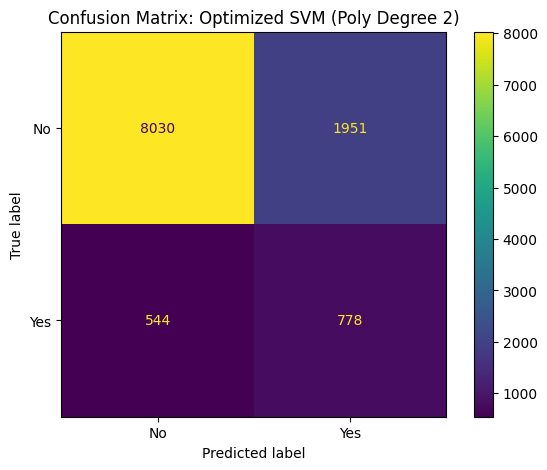

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    final_svm_model,
    X_test,
    y_test,
    display_labels=["No", "Yes"],
    ax=ax
)
plt.title("Confusion Matrix: Optimized SVM (Poly Degree 2)")
plt.show()

**Summarizing observations**


1.   Test precision score is marginally better than Training precision score indicating no overfitting
2.   Model has correctly identified 778 of customers signing up for the product. Precision is 29% (TP/TP+FP) significantly higher than 11% of total class ratio; This indicates that model is able to differentiate customers signing up for the product at a higher rate
3.   Recall is at 59% suggesting 59% of actual conversions are captured by the model





# Logistic Regression

In [29]:
best_logreg_params = {
    'C': 10,
    'penalty': 'l2',
    'solver': 'saga',
    'class_weight': None, # As determined by your GridSearch
    'max_iter': 5000,     # SAGA often needs more iterations to converge
    'random_state': 42
}

logreg_final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(**best_logreg_params))
])

# 2. Fit to your training data
logreg_final_model.fit(X_train, y_train)

# 3. Generate Predictions and Probabilities
logreg_test_preds = logreg_final_model.predict(X_test)
logreg_test_probs = logreg_final_model.predict_proba(X_test)[:, 1]

# 4. Evaluation
print(f"--- Logistic Regression Final Performance ---")
print(f"Test Average Precision: {average_precision_score(y_test, logreg_test_probs):.3f}")
print("\n--- Detailed Test Metrics ---")
print(classification_report(y_test, logreg_test_preds))

--- Logistic Regression Final Performance ---
Test Average Precision: 0.363

--- Detailed Test Metrics ---
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9981
           1       0.69      0.11      0.20      1322

    accuracy                           0.89     11303
   macro avg       0.79      0.55      0.57     11303
weighted avg       0.87      0.89      0.85     11303



In [30]:
train_probs = logreg_final_model.predict_proba(X_train)[:, 1]
test_probs = logreg_final_model.predict_proba(X_test)[:, 1]

# Calculate Average Precision
ap_train = average_precision_score(y_train, train_probs)
ap_test = average_precision_score(y_test, test_probs)

print(f"--- Model Generalization Check ---")
print(f"Train Average Precision: {ap_train:.3f}")
print(f"Test Average Precision:  {ap_test:.3f}")
print(f"Difference (Gap):        {ap_train - ap_test:.3f}")

# Standard Classification Report for the Test set
test_preds = logreg_final_model.predict(X_test)
print("\n--- Detailed Test Metrics ---")
print(classification_report(y_test, test_preds))

--- Model Generalization Check ---
Train Average Precision: 0.353
Test Average Precision:  0.363
Difference (Gap):        -0.010

--- Detailed Test Metrics ---
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9981
           1       0.69      0.11      0.20      1322

    accuracy                           0.89     11303
   macro avg       0.79      0.55      0.57     11303
weighted avg       0.87      0.89      0.85     11303



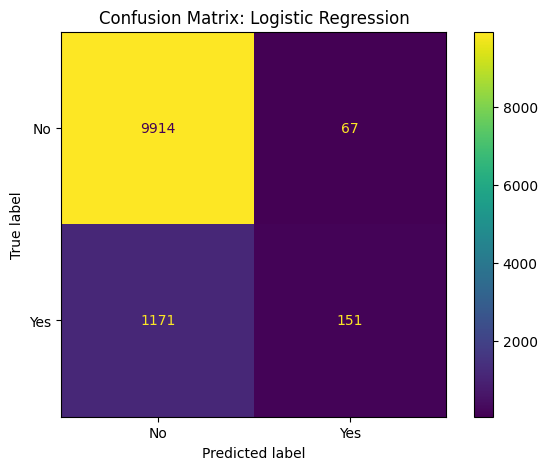

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    logreg_final_model,
    X_test,
    y_test,
    display_labels=["No", "Yes"],
    ax=ax
)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

**Summarizing observations**


1.   Test precision score is marginally better than Training precision score indicating no overfitting
2.   While the model has high precision but recall rate is very low (11%)





# KNN (Nearest Neighbors)

--- KNN Model Generalization Check ---
Train Average Precision: 1.000
Test Average Precision:  0.365
Difference (Gap):        0.635

--- Detailed Test Metrics (KNN) ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9981
           1       0.62      0.12      0.21      1322

    accuracy                           0.89     11303
   macro avg       0.76      0.56      0.57     11303
weighted avg       0.86      0.89      0.85     11303

--- KNN Final Performance ---
Test Average Precision: 0.365

--- Detailed Test Metrics ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9981
           1       0.62      0.12      0.21      1322

    accuracy                           0.89     11303
   macro avg       0.76      0.56      0.57     11303
weighted avg       0.86      0.89      0.85     11303



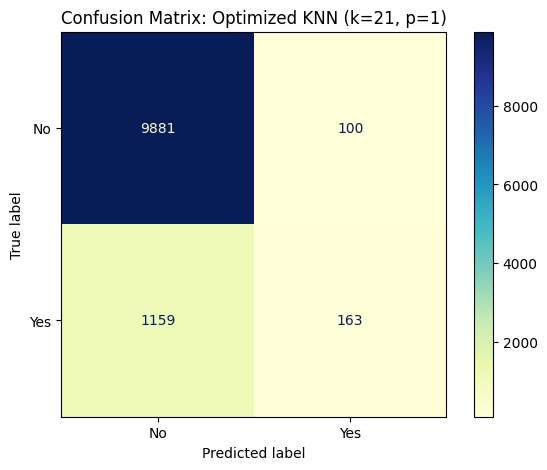

In [35]:
best_knn_params = {
    'n_neighbors': 21,
    'p': 1,
    'weights': 'distance'
}

knn_final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(**best_knn_params))
])

# 2. Fit to your training data
knn_final_model.fit(X_train, y_train)

# 3. Generate Predictions and Probabilities
knn_test_preds = knn_final_model.predict(X_test)
knn_test_probs = knn_final_model.predict_proba(X_test)[:, 1]

# 4. Get probability scores for both sets
train_probs_knn = knn_final_model.predict_proba(X_train)[:, 1]
test_probs_knn = knn_final_model.predict_proba(X_test)[:, 1]

# 5. Calculate Average Precision for both
ap_train_knn = average_precision_score(y_train, train_probs_knn)
ap_test_knn = average_precision_score(y_test, test_probs_knn)

print(f"--- KNN Model Generalization Check ---")
print(f"Train Average Precision: {ap_train_knn:.3f}")
print(f"Test Average Precision:  {ap_test_knn:.3f}")
print(f"Difference (Gap):        {ap_train_knn - ap_test_knn:.3f}")

# 6. Standard Classification Report for the Test set
knn_test_preds = knn_final_model.predict(X_test)
print("\n--- Detailed Test Metrics (KNN) ---")
print(classification_report(y_test, knn_test_preds))

# 7. Evaluation
print(f"--- KNN Final Performance ---")
print(f"Test Average Precision: {average_precision_score(y_test, knn_test_probs):.3f}")
print("\n--- Detailed Test Metrics ---")
print(classification_report(y_test, knn_test_preds))

# 5. Visualizing the Confusion Matrix
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    knn_final_model,
    X_test,
    y_test,
    display_labels=["No", "Yes"],
    cmap='YlGnBu',
    ax=ax
)
plt.title("Confusion Matrix: Optimized KNN (k=21, p=1)")
plt.show()

**Summarizing observations**


1.   Test precision score is significantly lower than Training precision score indicating it's highly overfit
2.   While the model has high precision but recall rate is very low (12%) missing majority of customers who could be targeted





# Decision Trees

In [23]:
best_dt_params = {
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': 10,
    'min_samples_leaf': 20,
    'random_state': 42
}

# Create and fit the pipeline
dt_final_model = Pipeline([
    ("dt", DecisionTreeClassifier(**best_dt_params))
])

dt_final_model.fit(X_train, y_train)

Pipeline(steps=[('dt',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=20,
                                        random_state=42))])

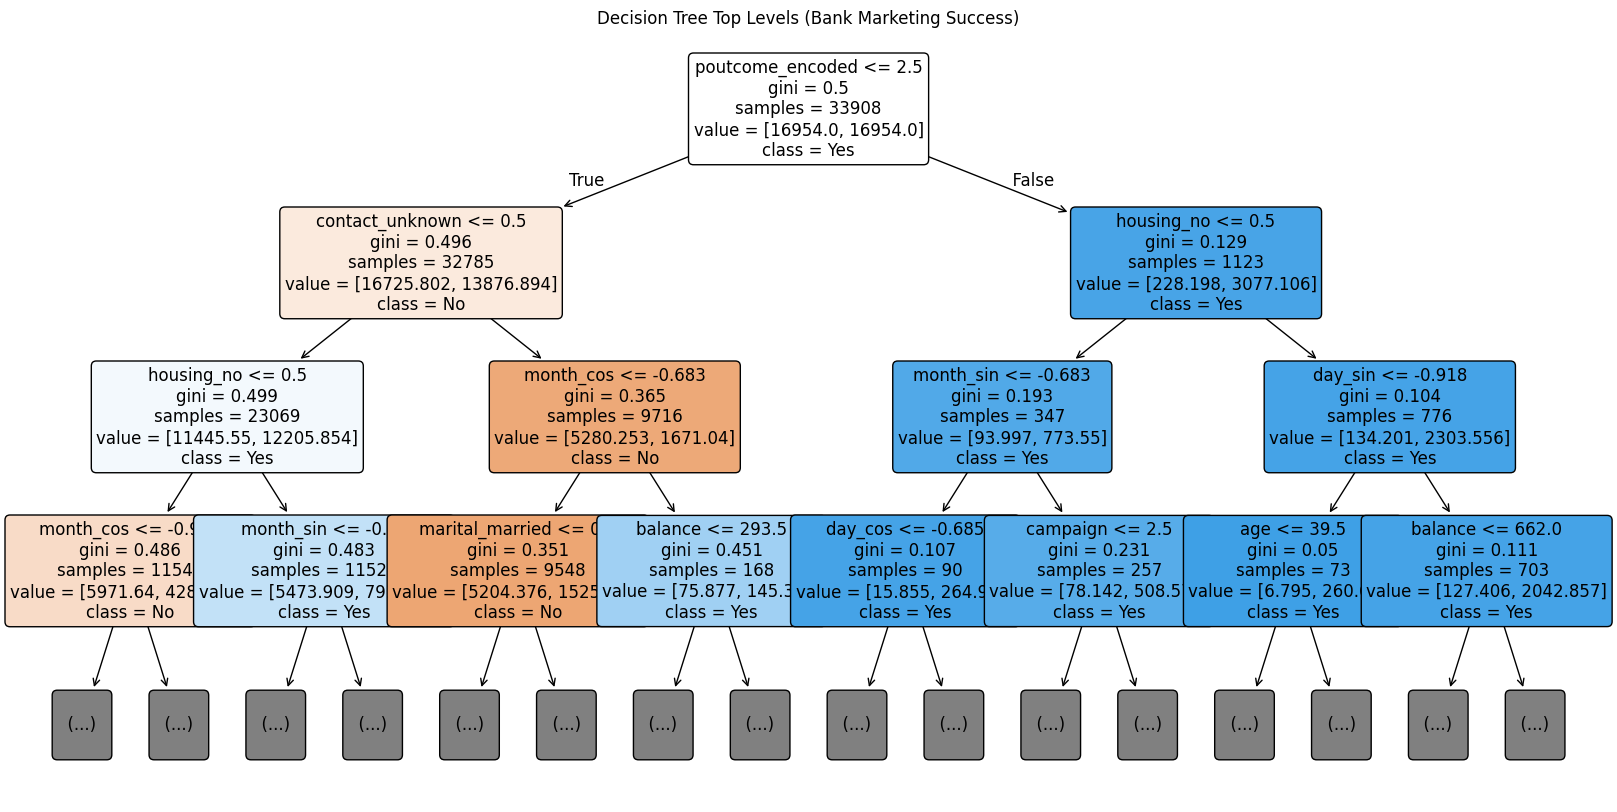

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Increase figsize for better clarity
plt.figure(figsize=(20, 10))

plot_tree(
    dt_final_model.named_steps['dt'],
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    filled=True,          # Colors nodes by majority class
    rounded=True,         # Rounded boxes
    fontsize=12,
    max_depth=3           # Only show the top 3 levels for readability
)

plt.title("Decision Tree Top Levels (Bank Marketing Success)")
plt.show()

--- Decision Tree Generalization Check ---
Train Average Precision: 0.484
Test Average Precision:  0.403
Difference (Gap):        0.081

--- Detailed Test Metrics (Decision Tree) ---
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      9981
           1       0.32      0.60      0.42      1322

    accuracy                           0.81     11303
   macro avg       0.63      0.72      0.65     11303
weighted avg       0.87      0.81      0.83     11303



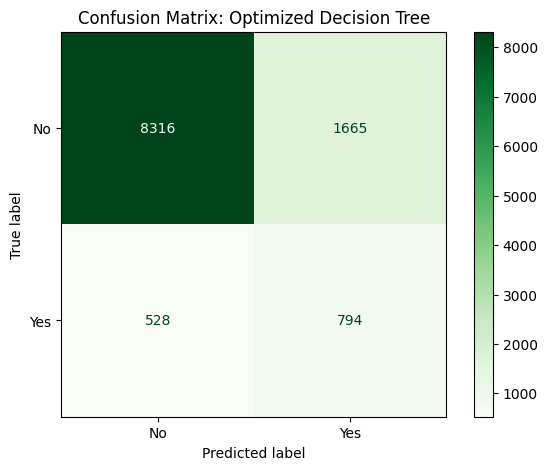

In [37]:
# Get probability scores
train_probs_dt = dt_final_model.predict_proba(X_train)[:, 1]
test_probs_dt = dt_final_model.predict_proba(X_test)[:, 1]

# Calculate Average Precision
ap_train_dt = average_precision_score(y_train, train_probs_dt)
ap_test_dt = average_precision_score(y_test, test_probs_dt)

print(f"--- Decision Tree Generalization Check ---")
print(f"Train Average Precision: {ap_train_dt:.3f}")
print(f"Test Average Precision:  {ap_test_dt:.3f}")
print(f"Difference (Gap):        {ap_train_dt - ap_test_dt:.3f}")

# Detailed Metrics
dt_test_preds = dt_final_model.predict(X_test)
print("\n--- Detailed Test Metrics (Decision Tree) ---")
print(classification_report(y_test, dt_test_preds))

#Confusion Matrix
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    dt_final_model,
    X_test,
    y_test,
    display_labels=["No", "Yes"],
    cmap='Greens',
    ax=ax
)
plt.title("Confusion Matrix: Optimized Decision Tree")
plt.show()

**Summary**


1.   Variance between test and training show notable difference of 0.08; Higher overfitting compared to SVM
2.   40% precision score and 60% recall rate is the highest; The model identified 794 true positive customers, highest vs other models



# **Recommendation**


*   Decision Tree and SVM models would identify maximum Sales conversion while Logistic regression and KNN is too conservative and doesn't serve the Business Purpose

*   While Decision tree minimizes in-vain marketing pursuits, the model is more generalized with SVM; Hence **recommendation is to use SVM Model for Marketing Campaign**

*   A/B test is recommended to truly evaluate incrementality of the model over Marketing intuition possessed by outbound agents; Given the comparitive performance of Decision tree, it would be okay to do A/B/C test pitting multiple models and Control population


